# **Spotify Song Popularity Prediction**
This Jupyter Notebook demonstrates an end-to-end machine learning workflow for predicting a song's popularity score using Spotify dataset.

## **Overview**
- Load and explore the dataset.
- Handle missing values and remove unnecessary features.
- Detect and remove outliers.
- Normalize numerical features.
- Convert categorical data to numerical values.
- Train multiple regression models and evaluate performance.
- Select the best model based on RMSE.
- Predict on test data and generate submission file.
- Visualize data and model insights.

---

In [33]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error


In [34]:
# Load training and test data
# The dataset contains song attributes and a popularity score

train_path = "CS98XRegressionTrain.csv"
test_path = "CS98XRegressionTest.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# Display basic information
print("Training Data Shape:", train_df.shape)
print("Test Data Shape:", test_df.shape)
train_df.head()


Training Data Shape: (453, 15)
Test Data Shape: (114, 14)


,Id,title,artist,top genre,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop
0,1,My Happiness,Connie Francis,adult standards,1996,107,31,45,-8,13,28,150,75,3,44
1,2,Unchained Melody,The Teddy Bears,NaN,2011,114,44,53,-8,13,47,139,49,3,37
2,3,How Deep Is Your Love,Bee Gees,adult standards,1979,105,36,63,-9,13,67,245,11,3,77
3,4,Woman in Love,Barbra Streisand,adult standards,1980,170,28,47,-16,13,33,232,25,3,67
4,5,Goodbye Yellow Brick Road - Remastered 2014,Elton John,glam rock,1973,121,47,56,-8,15,40,193,45,3,63


In [35]:
# Handle missing values
# Since 'top genre' has some missing values, we replace them with 'Unknown'
def clean_data(df):
    df = df.copy(deep=True)
    df['top genre'] = df['top genre'].fillna('Unknown')
    return df

train_df = clean_data(train_df)
test_df = clean_data(test_df)


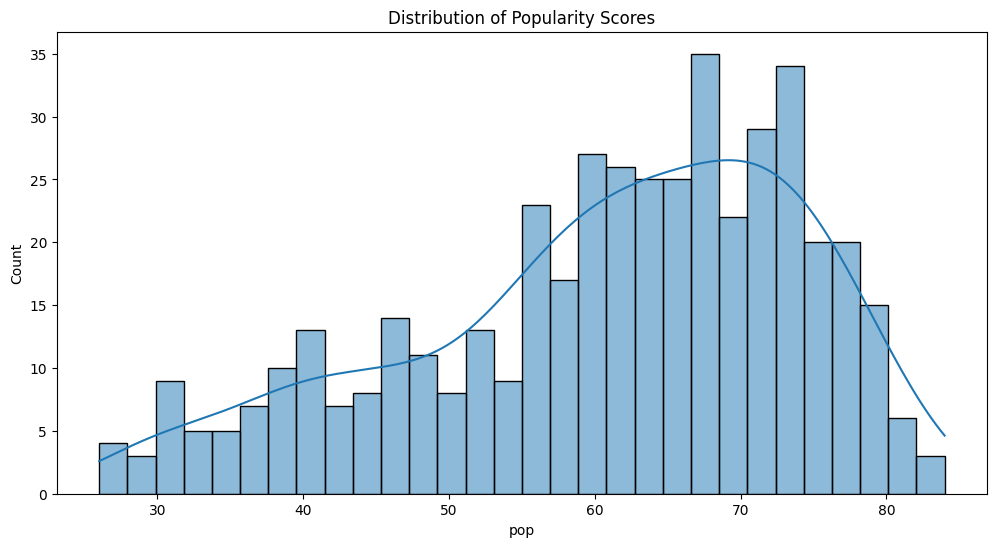

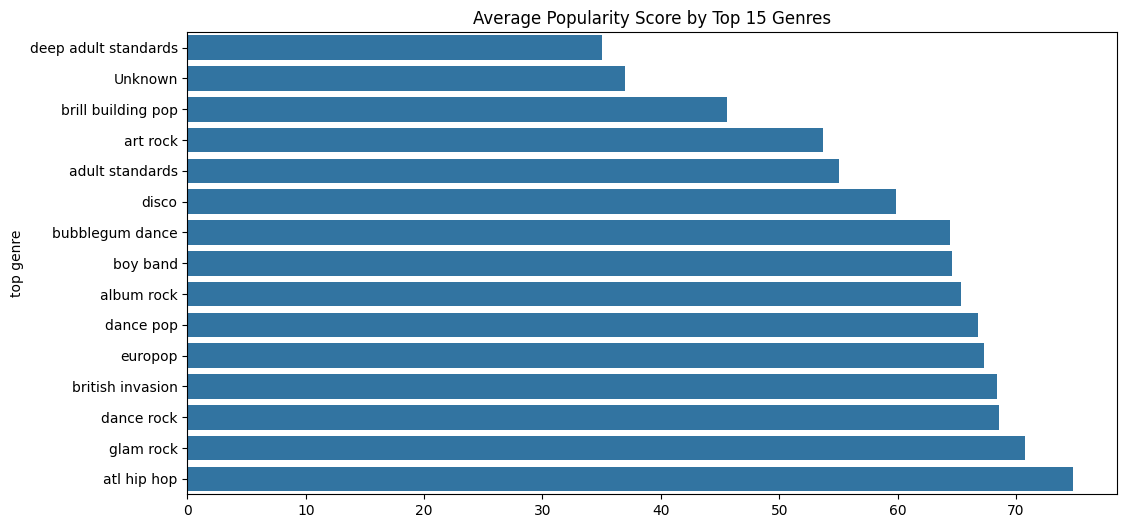

In [36]:
# Initial Data Visualization
# We visualize the distribution of popularity scores to understand its range and skewness
plt.figure(figsize=(12, 6))
sns.histplot(train_df['pop'], bins=30, kde=True)
plt.title("Distribution of Popularity Scores")
plt.show()

# Barplot for Genre Popularity (Showing Top 15 Genres)
# This helps us understand which genres tend to have higher popularity
plt.figure(figsize=(12, 6))
top_genres = train_df['top genre'].value_counts().index[:15]
genre_popularity = train_df[train_df['top genre'].isin(top_genres)].groupby('top genre')['pop'].mean().sort_values()
sns.barplot(x=genre_popularity.values, y=genre_popularity.index)
plt.title("Average Popularity Score by Top 15 Genres")
plt.show()


In [37]:
# Drop unnecessary columns that are not useful for model training
train_df.drop(columns=['Id', 'title', 'artist'], inplace=True)
test_ids = test_df['Id']
test_df.drop(columns=['Id', 'title', 'artist'], inplace=True)


In [38]:
# Remove outliers
# Outliers can negatively impact the model. We remove them using the IQR method.

def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

train_df = remove_outliers(train_df, 'bpm')
train_df = remove_outliers(train_df, 'dur')


In [39]:
# Normalize numerical features using MinMaxScaler
# This ensures all values are within the range of 0-1 for better model performance

numeric_features = ['year', 'bpm', 'nrgy', 'dnce', 'dB', 'live', 'val', 'dur', 'acous', 'spch']
scaler = MinMaxScaler()
train_df[numeric_features] = scaler.fit_transform(train_df[numeric_features])
test_df[numeric_features] = scaler.transform(test_df[numeric_features])


In [40]:
# Encode categorical data
# We convert categorical values into numerical values using Label Encoding

label_encoder = LabelEncoder()
train_df['top genre'] = label_encoder.fit_transform(train_df['top genre'])
test_df['top genre'] = test_df['top genre'].apply(lambda x: x if x in list(label_encoder.classes_) else 'Unknown Genre')
label_encoder.classes_ = np.append(label_encoder.classes_, 'Unknown Genre')
test_df['top genre'] = label_encoder.transform(test_df['top genre'])


In [41]:
# Train-test split
X = train_df.drop(columns=['pop'])
y = train_df['pop']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [42]:
# Train multiple regression models
# We compare different models to find the best one for our dataset

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42)
}

model_results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    model_results[name] = rmse


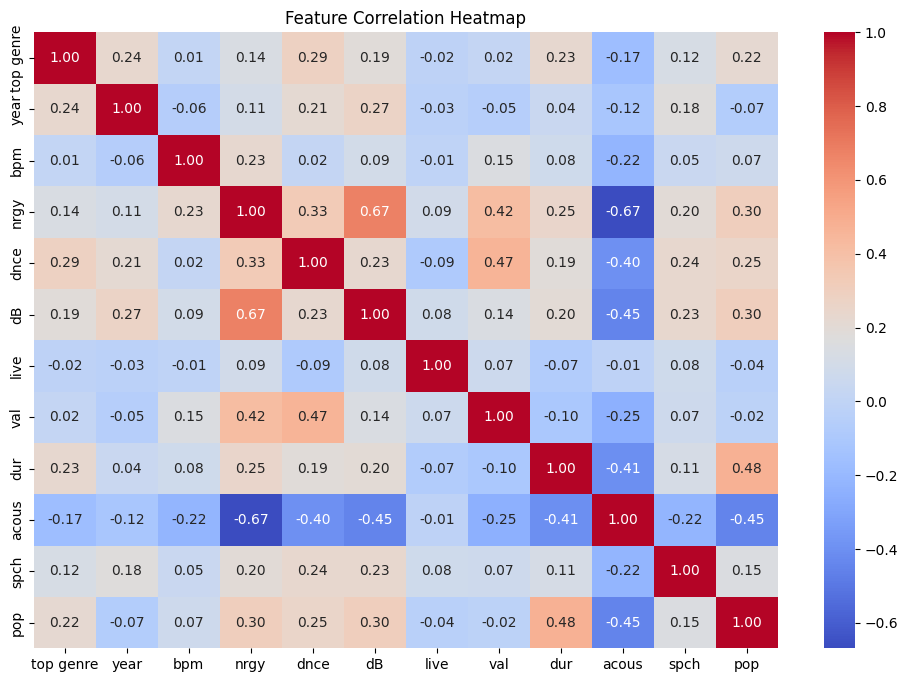

In [43]:
# Feature Correlation Heatmap
# This helps us understand relationships between different features
plt.figure(figsize=(12, 8))
sns.heatmap(train_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


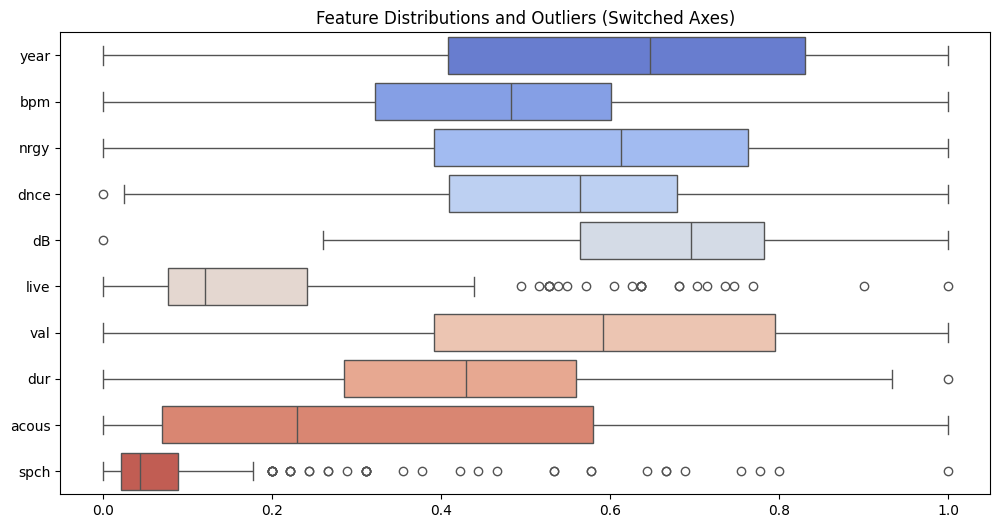

In [44]:
# Feature Distributions and Outliers (Boxplot with switched axes)
# This allows us to identify features with high variability and possible outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=train_df[numeric_features], orient='h', palette="coolwarm")
plt.title("Feature Distributions and Outliers (Switched Axes)")
plt.show()


In [45]:
# Select the best model based on RMSE
best_model_name = min(model_results, key=model_results.get)
best_model = models[best_model_name]
print("Best Model Selected:", best_model_name)
best_model.fit(X, y)


Best Model Selected: Gradient Boosting


GradientBoostingRegressor(random_state=42)

In [46]:
# Make predictions on test data
y_test_pred = best_model.predict(test_df)


In [47]:
# Save predictions
output_df = pd.DataFrame({'Id': test_ids, 'pop': y_test_pred.round().astype(int)})
output_df.to_csv("spotify_predictions.csv", index=False)
